## Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import random
from tqdm import tqdm

import time
import copy
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"L'entraînement se fera sur : {device}")

L'entraînement se fera sur : cuda


# Motivation du choix des Datasets

Pour sélectionner des datasets pertinents pour une comparaison rigoureuse, nous nous sommes basés sur les différences fondamentales de fonctionnement entre les deux architectures identifiées dans la littérature :

- Hypothèse CNN (Fort Biais Inductif) : Les CNNs, grâce à leurs opérations de convolution, possèdent un fort biais inductif (invariance par translation, localité). Ils sont théoriquement capables de généraliser efficacement même sur des images de faible résolution et des volumes de données modérés.

- Hypothèse ViT (Faible Biais Inductif) : Les Vision Transformers traitent l'image comme une séquence globale de "patches" sans hypothèses spatiales. Ils nécessitent généralement une plus grande résolution (pour avoir suffisamment de patches) et un volume de données massif pour apprendre les relations spatiales, risquant le surapprentissage sur de petits datasets.

Pour vérifier ces hypothèses et observer la transition de performance, nous avons sélectionné deux datasets aux caractéristiques distinctes:

- CIFAR-10 : Un dataset standard comportant 60 000 images couleur (50 000 pour l'entraînement, 10 000 pour le test) réparties équitablement en 10 classes. Avec une faible résolution de 32×32 pixels, ce dataset représente un défi pour le ViT standard (qui se retrouve avec très peu de patches) et servira de "baseline" favorable aux CNNs.

- Tiny ImageNet : Une version réduite du célèbre ImageNet, contenant 100 000 images d'entraînement et 10 000 images de validation, réparties en 200 classes (soit 500 images par classe). Avec une résolution de 64×64 pixels, il offre 4 fois plus de pixels que CIFAR-10 et une complexité de classification accrue, permettant de tester la capacité de généralisation des modèles.

Nous implémenterons les deux architectures "from scratch" pour comparer leurs performances sur ces deux échelles de complexité.

# Architecture ViT (Ezz)

Le ViT traite l'image comme une séquence de tokens. Le découpage standard de 16×16 pixels, conçu pour des images haute résolution (224×224), est inadapté à nos datasets (CIFAR-10, 32×32). En effet, cela ne génèrerait que 2×2=4 patches, un nombre insuffisant pour que le mécanisme d'Attention apprenne des dépendances spatiales complexes. Nous réduisons donc la taille des patches à 4×4 pixels. Cela permet de générer une séquence de 8×8=64 tokens, offrant un meilleur apprentissage.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size

        # On utilise une Conv2d avec kernel_size = stride = patch_size pour découper et projeter linéairement.
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: (Batch, C, H, W)
        x = self.projection(x) # (Batch, Embed_Dim, H/P, W/P)
        x = x.flatten(2)       # (Batch, Embed_Dim, N_Patches)
        x = x.transpose(1, 2)  # (Batch, N_Patches, Embed_Dim) -> Format attendu par le Transformer
        return x

La classe TransformerBlock est composée de deux sous-modules séquentiels connectés par des liens résiduels (skip connections) : un mécanisme de Self-Attention Multi-têtes (permettant à chaque patch d'intégrer l'information de tous les autres patches de l'image globalement) suivi d'un réseau de neurones MLP.

ici on utilise la LayerNorm qui stabilise l'apprentissage en normalisant les vecteurs de chaque échantillon individuellement (indépendamment des autres images du batch).

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, pf_dim, dropout=0.1):
        super().__init__()
        # 1. Self-Attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # 2. Feed Forward (MLP)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, pf_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Attention avec connexion résiduelle (Skip connection)
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        # MLP avec connexion résiduelle
        x = x + self.mlp(self.norm2(x))
        return x

Pour la classe finale qui assemble le tout, on va introduire 2 nouveaux concepts

- Le Token CLS (self.cls_token): C'est un vecteur apprenable unique ajouté en début de séquence (index 0). Grâce au mécanisme d'attention, il agrège les informations de tous les autres patches au fil des couches. C'est ce vecteur qui est utilisé pour prédire la classe de l'image.

- L'Embedding de Position (self.pos_embed): ce paramètre est additionné aux embeddings des patches pour injecter l'information spatiale. Il permet au modèle de distinguer la géométrie de l'image (savoir qu'un patch est en haut à gauche et non en bas à droite par exemple).

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=128, depth=6, num_heads=4, pf_dim=256, dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "L'image doit être divisible par la taille du patch."
        num_patches = (img_size // patch_size) ** 2

        # 1. Patch Embedding
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)

        # 2. CLS Token & Positional Embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim)) # +1 car on a ajouté le CLS token
        self.pos_drop = nn.Dropout(dropout)

        # 3. Transformer Encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, pf_dim, dropout)
            for _ in range(depth)
        ])

        # 4. Tête de classification finale
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.patch_embed(x)

        # B. Ajout du CLS Token
        # On duplique le token pour chaque image du batch
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (Batch, N_Patches + 1, Embed_Dim)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        # On ne garde que le CLS token (index 0) pour la prédiction
        cls_token_final = x[:, 0]
        return self.head(cls_token_final)

# Architecture CNN (Le Pape)

# Train and Test functions

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Entraîne le modèle et affiche les courbes d'évolution.
    """
    model = model.to(device)

    # Historique pour les tracés
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    print(f"Démarrage de l'entraînement pour {num_epochs} époques...")

    for epoch in range(num_epochs):
        start_time = time.time()

        # --- PHASE D'ENTRAÎNEMENT ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Barre de progression
        loop = tqdm(train_loader, leave=False)
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Stats train
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Mise à jour barre de progression
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train

        # --- PHASE DE VALIDATION ---
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val

        # Stockage
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
              f"Time: {time.time() - start_time:.1f}s")

    # --- TRACÉ DES COURBES ---
    plt.figure(figsize=(12, 5))

    # Courbe de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Courbe d'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Évolution de l\'Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.show()

    return history

In [ ]:
def evaluate_model(model, test_loader, classes, device='cuda'):
    """
    Calcule l'accuracy finale et affiche la matrice de confusion.
    """
    model.eval()
    all_preds = []
    all_labels = []

    print("Évaluation du modèle...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcul des métriques
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy Finale sur le jeu de test : {acc*100:.2f}%")

    if len(classes) <= 10:
      # Affichage de la matrice
      plt.figure(figsize=(10, 8))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=classes, yticklabels=classes)
      plt.xlabel('Prédiction')
      plt.ylabel('Vraie Classe')
      plt.title('Matrice de Confusion')
      plt.show()

# Définition des classes CIFAR-10 pour l'affichage
classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

# Architecture ViT

Le ViT traite l'image comme une séquence de tokens. Le découpage standard de 16×16 pixels, conçu pour des images haute résolution (224×224), est inadapté à nos datasets (CIFAR-10, 32×32). En effet, cela ne génèrerait que 2×2=4 patches, un nombre insuffisant pour que le mécanisme d'Attention apprenne des dépendances spatiales complexes. Nous réduisons donc la taille des patches à 4×4 pixels. Cela permet de générer une séquence de 8×8=64 tokens, offrant un meilleur apprentissage.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size

        # On utilise une Conv2d avec kernel_size = stride = patch_size pour découper et projeter linéairement.
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: (Batch, C, H, W)
        x = self.projection(x) # (Batch, Embed_Dim, H/P, W/P)
        x = x.flatten(2)       # (Batch, Embed_Dim, N_Patches)
        x = x.transpose(1, 2)  # (Batch, N_Patches, Embed_Dim) -> Format attendu par le Transformer
        return x

La classe TransformerBlock est composée de deux sous-modules séquentiels connectés par des liens résiduels (skip connections) : un mécanisme de Self-Attention Multi-têtes (permettant à chaque patch d'intégrer l'information de tous les autres patches de l'image globalement) suivi d'un réseau de neurones MLP.

ici on utilise la LayerNorm qui stabilise l'apprentissage en normalisant les vecteurs de chaque échantillon individuellement (indépendamment des autres images du batch).

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, pf_dim, dropout=0.1):
        super().__init__()
        # 1. Self-Attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # 2. Feed Forward (MLP)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, pf_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Attention avec connexion résiduelle (Skip connection)
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        # MLP avec connexion résiduelle
        x = x + self.mlp(self.norm2(x))
        return x

Pour la classe finale qui assemble le tout, on va introduire 2 nouveaux concepts

- Le Token CLS (self.cls_token): C'est un vecteur apprenable unique ajouté en début de séquence (index 0). Grâce au mécanisme d'attention, il agrège les informations de tous les autres patches au fil des couches. C'est ce vecteur qui est utilisé pour prédire la classe de l'image.

- L'Embedding de Position (self.pos_embed): ce paramètre est additionné aux embeddings des patches pour injecter l'information spatiale. Il permet au modèle de distinguer la géométrie de l'image (savoir qu'un patch est en haut à gauche et non en bas à droite par exemple).

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=128, depth=6, num_heads=4, pf_dim=256, dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "L'image doit être divisible par la taille du patch."
        num_patches = (img_size // patch_size) ** 2

        # 1. Patch Embedding
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)

        # 2. CLS Token & Positional Embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim)) # +1 car on a ajouté le CLS token
        self.pos_drop = nn.Dropout(dropout)

        # 3. Transformer Encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, pf_dim, dropout)
            for _ in range(depth)
        ])

        # 4. Tête de classification finale
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.patch_embed(x)

        # B. Ajout du CLS Token
        # On duplique le token pour chaque image du batch
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (Batch, N_Patches + 1, Embed_Dim)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        # On ne garde que le CLS token (index 0) pour la prédiction
        cls_token_final = x[:, 0]
        return self.head(cls_token_final)

# CIFAR-10


## ViT

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Définition des classes CIFAR-10 pour l'affichage
classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

val_size = 5000
train_size = len(trainset) - val_size

# Utilisation du générateur pour garantir que le split est toujours le même (Reproductibilité)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(trainset, [train_size, val_size], generator=generator)

batch_size = 64

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Données chargées :")
print(f"- Train : {len(train_dataset)} images")
print(f"- Val   : {len(val_dataset)} images")
print(f"- Test  : {len(testset)} images")

 15%|█▌        | 25.7M/170M [00:01<00:06, 23.7MB/s]


KeyboardInterrupt: 

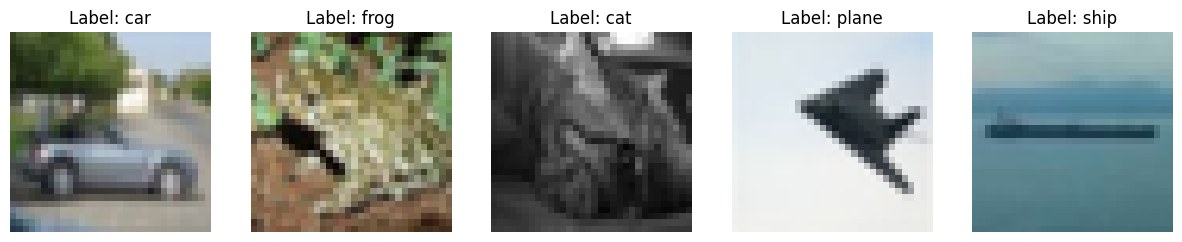

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# images aléatoires du trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)


plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    imshow(images[i])
    ax.set_title(f"Label: {classes[labels[i]]}")
    plt.axis('off')

plt.show()

In [ ]:
def visualize_patches(image, patch_size):
    # image: (C, H, W) tensor
    # patch_size: int

    C, H, W = image.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size."

    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    fig, axes = plt.subplots(num_patches_h, num_patches_w, figsize=(num_patches_w * 1.5, num_patches_h * 1.5))
    axes = axes.flatten()

    patch_idx = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Extract the patch
            patch = image[:, i * patch_size : (i + 1) * patch_size, j * patch_size : (j + 1) * patch_size]

            # Convert to numpy and transpose for matplotlib (H, W, C)
            patch_np = patch.permute(1, 2, 0).cpu().numpy()

            ax = axes[patch_idx]
            ax.imshow(np.clip(patch_np, 0, 1))
            ax.set_title(f'Patch {patch_idx+1}', fontsize=8)
            ax.axis('off')
            patch_idx += 1

    plt.suptitle(f'Image divisée en patches de {patch_size}x{patch_size}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
model_vit = ViT(img_size=32, patch_size=4, num_classes=10, embed_dim=128, depth=6, num_heads=4).to(device)

# 2. Hyperparamètres
# AdamW est recommandé pour les Transformers
optimizer = optim.AdamW(model_vit.parameters(), lr=3e-4, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

Démarrage de l'entraînement pour 15 époques...


Epoch 1/15 | Train Loss: 1.9649 Acc: 27.44% | Val Loss: 1.7813 Acc: 35.38% | Time: 25.5s


Epoch 2/15 | Train Loss: 1.7237 Acc: 37.70% | Val Loss: 1.5949 Acc: 43.02% | Time: 29.6s


Epoch 3/15 | Train Loss: 1.5954 Acc: 42.62% | Val Loss: 1.5794 Acc: 44.42% | Time: 29.8s


Epoch 4/15 | Train Loss: 1.5056 Acc: 45.88% | Val Loss: 1.4400 Acc: 48.48% | Time: 32.4s


Epoch 5/15 | Train Loss: 1.4449 Acc: 48.11% | Val Loss: 1.3696 Acc: 51.90% | Time: 23.2s


Epoch 6/15 | Train Loss: 1.3946 Acc: 49.95% | Val Loss: 1.3543 Acc: 51.42% | Time: 23.6s


Epoch 7/15 | Train Loss: 1.3559 Acc: 51.20% | Val Loss: 1.3275 Acc: 53.06% | Time: 35.6s


Epoch 8/15 | Train Loss: 1.3158 Acc: 52.69% | Val Loss: 1.2830 Acc: 54.34% | Time: 23.3s


Epoch 9/15 | Train Loss: 1.2777 Acc: 54.01% | Val Loss: 1.2459 Acc: 55.70% | Time: 23.2s


Epoch 10/15 | Train Loss: 1.2351 Acc: 55.61% | Val Loss: 1.2208 Acc: 56.52% | Time: 23.1s


Epoch 11/15 | Train Loss: 1.2043 Acc: 56.64% | Val Loss: 1.1995 Acc: 57.68% | Time: 23.8s


Epoch 12/15 | Train Loss: 1.1765 Acc: 57.82% | Val Loss: 1.1943 Acc: 58.00% | Time: 22.9s


Epoch 13/15 | Train Loss: 1.1432 Acc: 59.00% | Val Loss: 1.2056 Acc: 58.10% | Time: 23.2s


Epoch 14/15 | Train Loss: 1.1111 Acc: 60.05% | Val Loss: 1.1821 Acc: 58.98% | Time: 23.3s


Epoch 15/15 | Train Loss: 1.0878 Acc: 61.05% | Val Loss: 1.1735 Acc: 58.76% | Time: 23.6s


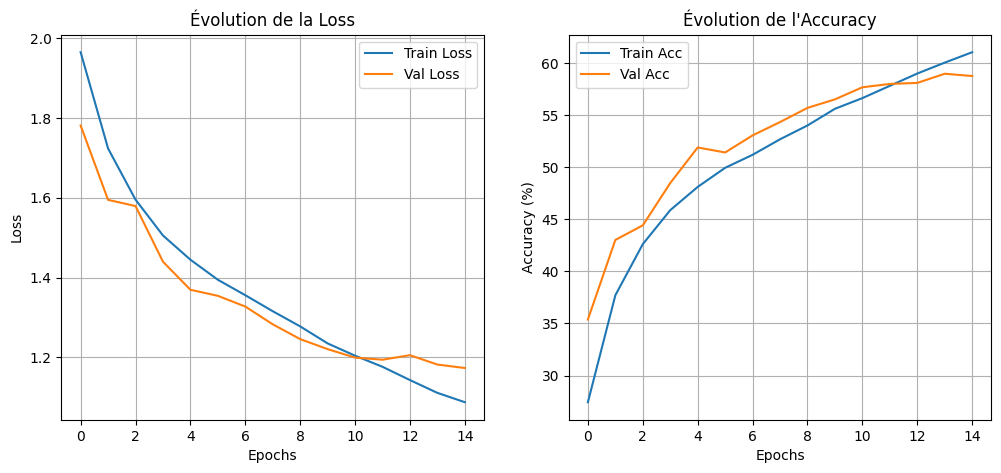

Évaluation du modèle...


100%|██████████| 157/157 [00:02<00:00, 71.03it/s]



Accuracy Finale sur le jeu de test : 58.90%


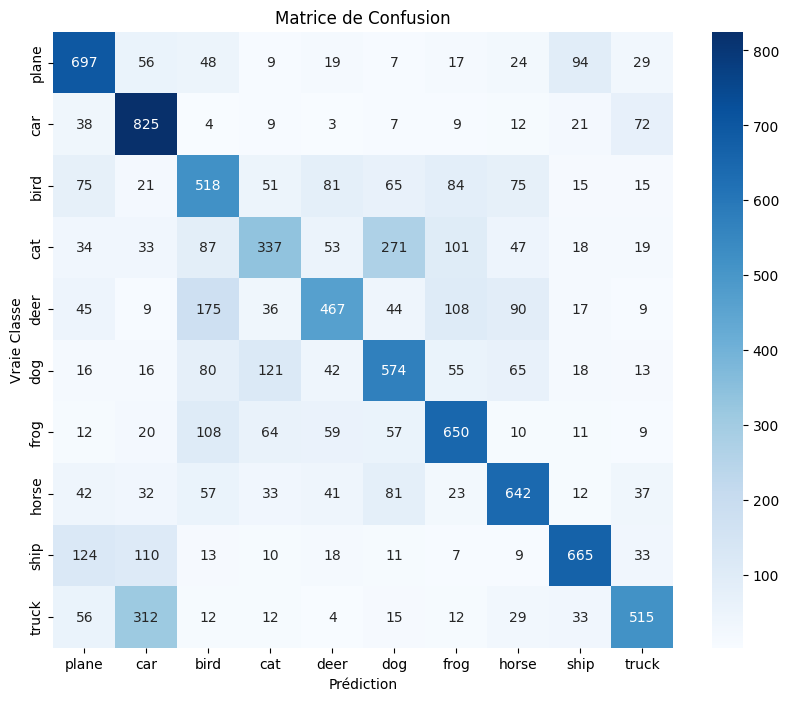

In [ ]:
# Lancer l'entraînement (Commence avec 10 ou 20 epochs pour tester)
history_vit = train_model(model_vit, trainloader, valloader, criterion, optimizer, num_epochs=15, device=device)

# Lancer l'évaluation finale
evaluate_model(model_vit, testloader, classes, device=device)

# Tiny ImageNet

## ViT

In [ ]:
from datasets import load_dataset
ds = load_dataset("zh-plus/tiny-imagenet")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [ ]:
class HFDatasetWrapper(torch.utils.data.Dataset):
    """
    Sert de pont entre le dataset Hugging Face et PyTorch.
    Convertit les images en RGB (certaines sont en noir et blanc dans TinyImageNet)
    et applique les transformations.
    """
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']
        label = item['label']

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

full_train_wrapper = HFDatasetWrapper(ds['train'], transform=transform)
tiny_test_dataset = HFDatasetWrapper(ds['valid'], transform=transform)

val_size = int(0.1 * len(full_train_wrapper)) # 10 000 images
train_size = len(full_train_wrapper) - val_size # 90 000 images
generator = torch.Generator().manual_seed(42)
tiny_train_dataset, tiny_val_dataset = random_split(full_train_wrapper, [train_size, val_size], generator=generator)

batch_size = 64
trainloader_tiny = DataLoader(tiny_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_tiny = DataLoader(tiny_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_tiny = DataLoader(tiny_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Split Tiny ImageNet terminé :")
print(f"- Train      : {len(tiny_train_dataset)} images (pour apprendre)")
print(f"- Validation : {len(tiny_val_dataset)} images (pour surveiller)")
print(f"- Test       : {len(tiny_test_dataset)} images (pour le verdict final)")

Split Tiny ImageNet terminé :
- Train      : 90000 images (pour apprendre)
- Validation : 10000 images (pour surveiller)
- Test       : 10000 images (pour le verdict final)


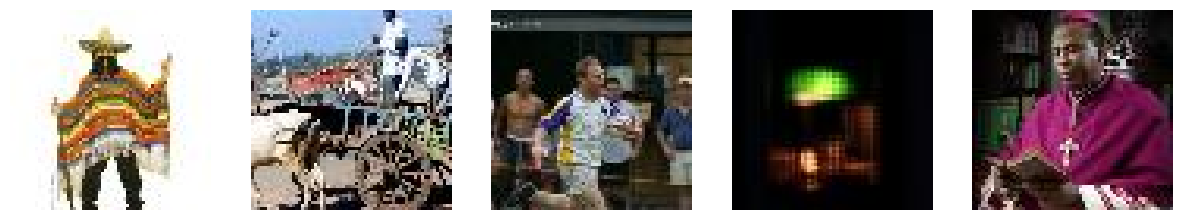

In [ ]:
# images aléatoires du trainloader
dataiter_tiny = iter(trainloader_tiny)
images, labels = next(dataiter_tiny)


plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    imshow(images[i])
    plt.axis('off')

plt.show()

In [ ]:
model_vit_tiny = ViT(img_size=64, patch_size=8, num_classes=200, embed_dim=128, depth=6, num_heads=4).to(device)

optimizer = optim.AdamW(model_vit_tiny.parameters(), lr=3e-4, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

Démarrage de l'entraînement pour 30 époques...


Epoch 1/30 | Train Loss: 5.0382 Acc: 2.33% | Val Loss: 4.7693 Acc: 4.74% | Time: 69.8s


Epoch 2/30 | Train Loss: 4.6417 Acc: 6.30% | Val Loss: 4.4880 Acc: 8.63% | Time: 75.3s


Epoch 3/30 | Train Loss: 4.3826 Acc: 9.57% | Val Loss: 4.2597 Acc: 11.04% | Time: 70.3s


Epoch 4/30 | Train Loss: 4.1842 Acc: 12.23% | Val Loss: 4.0923 Acc: 13.39% | Time: 69.2s


Epoch 5/30 | Train Loss: 4.0253 Acc: 14.36% | Val Loss: 3.9865 Acc: 15.06% | Time: 70.4s


Epoch 6/30 | Train Loss: 3.9099 Acc: 16.01% | Val Loss: 3.9176 Acc: 16.43% | Time: 69.1s


Epoch 7/30 | Train Loss: 3.8000 Acc: 17.46% | Val Loss: 3.8384 Acc: 17.84% | Time: 69.0s


Epoch 8/30 | Train Loss: 3.7063 Acc: 19.00% | Val Loss: 3.7674 Acc: 18.83% | Time: 70.3s


Epoch 9/30 | Train Loss: 3.6159 Acc: 20.43% | Val Loss: 3.7291 Acc: 19.41% | Time: 70.3s


Epoch 10/30 | Train Loss: 3.5387 Acc: 21.64% | Val Loss: 3.6689 Acc: 20.41% | Time: 70.7s


Epoch 11/30 | Train Loss: 3.4615 Acc: 22.86% | Val Loss: 3.6300 Acc: 21.41% | Time: 69.4s


Epoch 12/30 | Train Loss: 3.3874 Acc: 23.94% | Val Loss: 3.6131 Acc: 21.37% | Time: 70.4s


Epoch 13/30 | Train Loss: 3.3202 Acc: 25.10% | Val Loss: 3.5618 Acc: 22.74% | Time: 69.0s


Epoch 14/30 | Train Loss: 3.2505 Acc: 26.26% | Val Loss: 3.5571 Acc: 22.08% | Time: 70.4s


Epoch 15/30 | Train Loss: 3.1835 Acc: 27.28% | Val Loss: 3.5282 Acc: 23.14% | Time: 69.7s


Epoch 16/30 | Train Loss: 3.1257 Acc: 28.26% | Val Loss: 3.5117 Acc: 23.40% | Time: 69.6s


Epoch 17/30 | Train Loss: 3.0652 Acc: 29.20% | Val Loss: 3.4919 Acc: 23.52% | Time: 69.8s


Epoch 18/30 | Train Loss: 3.0041 Acc: 30.50% | Val Loss: 3.4925 Acc: 23.91% | Time: 68.9s


Epoch 19/30 | Train Loss: 2.9441 Acc: 31.53% | Val Loss: 3.4639 Acc: 24.74% | Time: 70.2s


Epoch 20/30 | Train Loss: 2.8843 Acc: 32.62% | Val Loss: 3.4643 Acc: 24.35% | Time: 69.0s


Epoch 21/30 | Train Loss: 2.8294 Acc: 33.27% | Val Loss: 3.4710 Acc: 24.56% | Time: 69.2s


Epoch 22/30 | Train Loss: 2.7759 Acc: 34.43% | Val Loss: 3.4867 Acc: 24.74% | Time: 69.7s


Epoch 23/30 | Train Loss: 2.7260 Acc: 35.07% | Val Loss: 3.4626 Acc: 24.91% | Time: 68.8s


Epoch 24/30 | Train Loss: 2.6766 Acc: 36.04% | Val Loss: 3.4703 Acc: 25.01% | Time: 69.9s


Epoch 25/30 | Train Loss: 2.6253 Acc: 37.05% | Val Loss: 3.4808 Acc: 25.35% | Time: 69.3s


Epoch 26/30 | Train Loss: 2.5783 Acc: 37.90% | Val Loss: 3.4944 Acc: 25.60% | Time: 69.9s


Epoch 27/30 | Train Loss: 2.5280 Acc: 38.65% | Val Loss: 3.4810 Acc: 25.41% | Time: 70.6s


Epoch 28/30 | Train Loss: 2.4840 Acc: 39.64% | Val Loss: 3.4925 Acc: 25.50% | Time: 68.8s


Epoch 29/30 | Train Loss: 2.4437 Acc: 40.30% | Val Loss: 3.5229 Acc: 25.39% | Time: 69.8s


Epoch 30/30 | Train Loss: 2.4027 Acc: 41.07% | Val Loss: 3.5256 Acc: 26.09% | Time: 68.6s


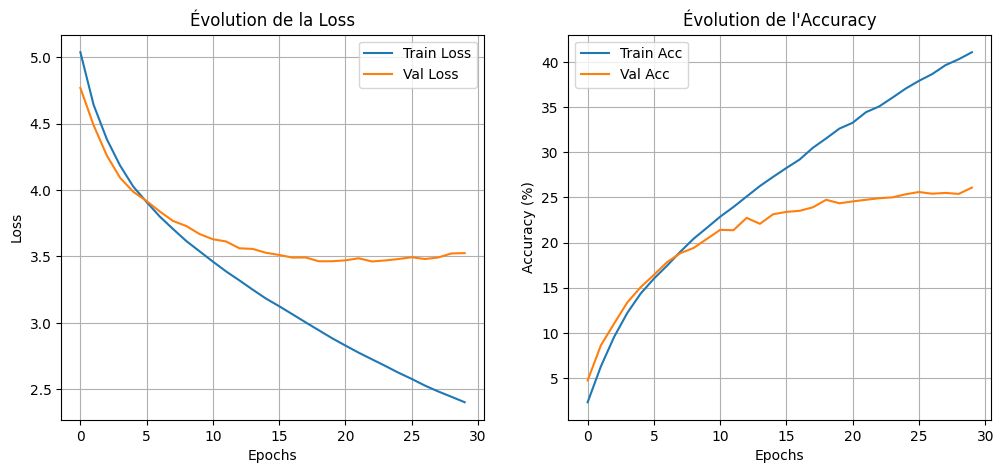

Évaluation du modèle...


100%|██████████| 157/157 [00:05<00:00, 30.41it/s]



Accuracy Finale sur le jeu de test : 26.25%


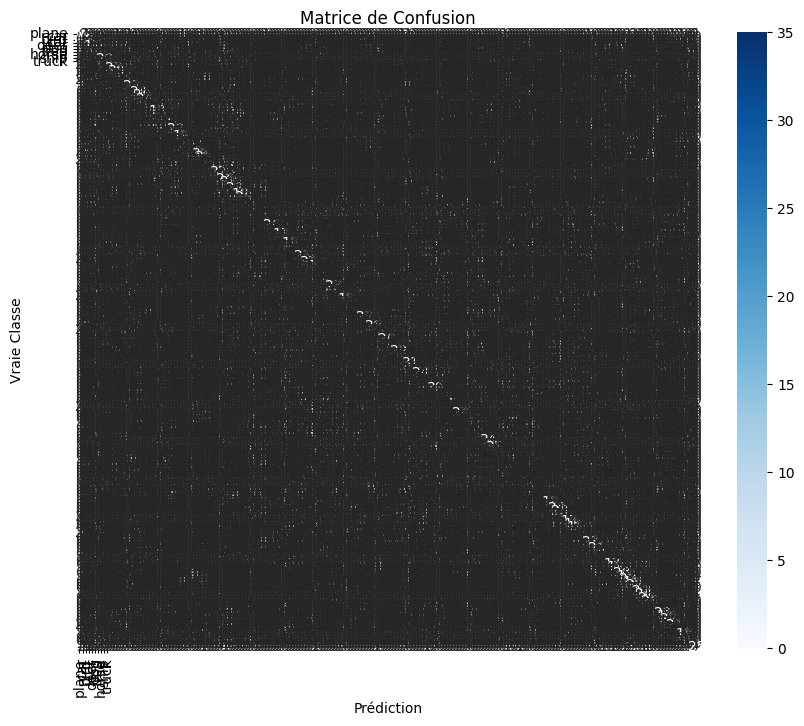

In [ ]:
history_vit = train_model(model_vit_tiny, trainloader_tiny, valloader_tiny, criterion, optimizer, num_epochs=30, device=device)

evaluate_model(model_vit_tiny, testloader_tiny, classes, device=device)